# Comparison of Search Method
This notebook describes how we compare the performance of our ML algorithm to other possible choices

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook as tqdm
import pandas as pd
import os
import numpy as np
import json

In [2]:
train_size = 1000
test_size = 20000
n_repeats = 25
pick_size = 50

## Load in the Known Data

In [3]:
def load_data(path):
    """Read in a JSON file from disk, and return a DataFrame with columns as attributes and class"""
    
    temp = json.load(open(path))
    data = pd.DataFrame([x['attributes']+[x['class']['measured'],] for x in temp['entries']],
                        columns=temp['attribute-names']+['class',])
    data = data[~data['class'].isnull()]
    return data
data = load_data(os.path.join('..', 'datasets', 'quat-heuslers.json'))

In [4]:
count = len(data)
n_stable = (data['class'] <= 0).sum()
print('Number of stable QHs: %d/%d'%(n_stable, count))

Number of stable QHs: 352/96188


In [5]:
print('Expected number of stable / test split:', n_stable / count * test_size)

Expected number of stable / test split: 73.190002911


Load in OQMD/TH data

In [6]:
other_data = pd.concat([load_data(os.path.join('..', 'datasets', '%s.json'%x)) 
                        for x in ['oqmd-no-heusler', 'heuslers']])

In [7]:
other_data = other_data[np.logical_not(np.any(other_data.isnull(), axis=1))]

## Implementing the Search Strategies
Each of these methods must take two arguements: "known" data for training, and the search space. Both arguments are Pandas data frames, and the method must return `pick_size` number of rows from that dataframe.

In [8]:
tests = dict()

### Random Search
Just pick rows randomly

In [9]:
def random_search(train_data, search_data):
    return search_data.sample(pick_size)

In [10]:
tests['Random\nSearch'] = random_search

### Valence Electron Counting
Prioritize compounds with 18 or 24 electrons

In [11]:
def valence_count(train_data, search_data):
    search_data = search_data.copy()
    search_data['matches'] = np.logical_or(np.isclose(search_data['mean_NValance'], 18.0 / 4),
                                           np.isclose(search_data['mean_NValance'], 24.0 / 4))
    return search_data.sample(len(search_data)).sort_values('matches', ascending=False).iloc[:pick_size]

In [12]:
tests['Electron\nCounting'] = valence_count 

### Machine Learning Method
Train an ML model using the method demonstrated in this work

In [13]:
X_cols = data.columns[:-1]
y_col = data.columns[-1]

In [14]:
model = Pipeline([
    ('imputer', Imputer()),
    ('rf', RandomForestRegressor(n_estimators=100, n_jobs=-1))
])

In [15]:
def ml_method(train_data, test_data):
    # Train the model
    model.fit(train_data[X_cols].astype(np.float32), train_data[y_col])
    
    # Predict stability
    test_data = test_data.copy()
    test_data['prediction'] = model.predict(test_data[X_cols])
    return test_data.sort_values('prediction', ascending=True).iloc[:pick_size]

In [16]:
tests['Ward,\nonly QH'] = ml_method

In [17]:
def ml_with_oqmd(train_data, test_data):
    return ml_method(pd.concat([train_data, other_data]), test_data)

In [18]:
tests['Ward,\nall OQMD'] = ml_with_oqmd

## Running the Test
For those methods we can test here

In [19]:
results = dict([(k,[]) for k in tests.keys()])
for i in tqdm(range(n_repeats), desc='Test'):
    train_data, test_data = train_test_split(data, train_size=train_size, test_size=test_size, random_state=i)
    for k,f in tests.items():
        results[k].append(sum(f(train_data, test_data)['class'] <= 0))

Widget Javascript not detected.  It may not be installed or enabled properly.


### Importing the Data
For tests that run elsewhere

In [20]:
results['Faber\nMethod'] = json.load(open('faber-result.json'))

In [21]:
results['DMSP'] = json.load(open('dmsp.json'))

## Plot Results


In [22]:
test_names = list(results.keys())
test_results = pd.DataFrame({
    'name': test_names,
    'mean': [np.mean(results[n]) for n in test_names],
    'error': [np.std(results[n]) / np.sqrt(n_repeats) for n in test_names]
})
test_results.sort_values('mean', ascending=False, inplace=True)

In [23]:
test_results

,error,mean,name
4,0.988704,12.04,Faber\nMethod
3,0.549385,7.88,"Ward,\nall OQMD"
2,0.441814,3.60,"Ward,\nonly QH"
5,0.428878,2.96,DMSP
1,0.114822,0.52,Electron\nCounting
0,0.080000,0.20,Random\nSearch


In [24]:
test_results.to_csv('test-results.csv', index=False)

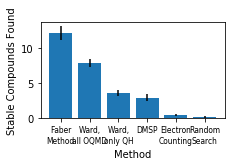

In [25]:
fig, ax = plt.subplots()

ticks = list(range(len(test_results)))
ax.bar(ticks, test_results['mean'], yerr=test_results['error'])

ax.set_xticks(ticks)
ax.set_xticklabels(test_results['name'], fontsize=7.5)

ax.set_xlabel('Method')
ax.set_ylabel('Stable Compounds Found')

fig.set_size_inches(89 / 25.4, 2.25)
fig.tight_layout()
fig.savefig('search-method-comparison.png', dpi=320)
fig.savefig('search-method-comparison.pdf')